# Action Priors in 1D

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import datetime

from IPython.core.debugger import set_trace

In [2]:
import time
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# load env
from src.envs.LinearEnv import LinearEnv


# cell magic for reloading imported modules
%load_ext autoreload

In [3]:
import gym

In [4]:
%autoreload 2
# instantiate env
env = gym.make("Pendulum-v0")

## Random Agent

In [5]:
# random agent
def random_agent(obs):
    return {"Action":np.random.uniform(-0.3,0.3,size=(1,))}

In [6]:
# run a single episode for an agent in the environment and return the rollout

def get_episode_trajectory(env, agent, max_steps=1000):
    observation_list = []
    reward_list = []
    action_list = []
    value_list = []

    env = gym.make("Pendulum-v0")
    done = False
    obs = env.reset()
    for i in range(max_steps):
        
        observation_list.append(obs.copy())
        out = agent(obs)
        
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, rew, done, _, = env.step(action)
        reward_list.append(rew)
        action_list.append(action.copy())
        if "Value" in out:
            value_list.append(out["Value"])
        env.render(mode='human')   
        if done:
            env.close()
            break
        
    ret = {
        "Observations": observation_list, 
        "Actions": action_list, 
        "Rewards": np.array(reward_list, dtype=np.float32)
    }
    if len(value_list) > 0:
        ret["Values"] = value_list
        
        
    return ret

In [7]:
def reward_to_go(rewards):
    return np.flip(np.cumsum(np.flip(rewards)))
def returns(rewards):
    gamma = 0.9
    ret = 0
    for t in range(len(rewards)):
        ret += (gamma**t) * ret 
    return np.sum(rewards)

$$
\large \nabla_{\theta}J(\theta) \approx \frac{1}{N}\sum \limits_{i = 1}^{N}\left( \nabla_{\theta}\sum \limits_{t = 1}^{T} log\pi_{\theta}(s_{i,t}\mid a_{i,t})\right)\left( \sum \limits_{t = 1}^{T}\gamma^t r(s_{i,t},a_{i,t}) - b\right)
$$

## Training Loop

In [8]:
def train_policy_grad(env, agent, num_epochs=250):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/' + current_time + '/train'
    # test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
       
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    log_reward = 0
    log_reward_list = []
    logging_period = 1
    num_trajectories = 3
    
    for epoch in range(num_epochs):
        
        obs_list = []
        rew_list = []
        actions_list = []
        returns_list = []
        log_probs_list = []
        
        epoch_gradients = []
        for i in range(num_trajectories):
            with tf.GradientTape(persistent=True) as tape:
                traj = get_episode_trajectory(env, agent) # trajectories may vary in length
                
                # lists no longer needed
                obs_list.append(np.stack(traj["Observations"]))
                actions_list.append(traj["Actions"])
                # compute 'reward-to-go'
                # rew_2_go = reward_to_go(rew)
                returns_list.append(np.sum(traj["Rewards"]))

                log_probs = agent.action_dist.log_prob(traj["Actions"])

                log_prob_sum = tf.reduce_sum(log_probs)
                
            # compute baseline
            baseline = 0

            # compute gradients + update weights
            traj_gradients = []
            for layer in agent_mlp_tf.trainable_variables:
                
                # layer_grad_log_sum = -1*tape.gradient(log_prob_sum, layer)*(np.sum(reward_to_go(traj["Rewards"])) - baseline)
                layer_grad_log_sum = -1*tape.gradient(log_prob_sum, layer)*returns(traj["Rewards"])
                traj_gradients.append(layer_grad_log_sum)
            epoch_gradients.append(traj_gradients)
        
        gradients = []
        for i in range(len(agent.trainable_variables)):
            l_grads = []
            for row, traj_grads in enumerate(epoch_gradients):
                l_grads.append(traj_grads[i])
                       
            gradients.append(tf.reduce_mean(l_grads,axis=0))
        
        
        optimizer.apply_gradients(zip(gradients, agent.trainable_variables))
        
        
        with train_summary_writer.as_default():
            tf.summary.scalar('Return', np.mean(returns_list), step=epoch)
#             tf.summary.histogram("Action", tf.reduce_mean(out["Action"]) , step=epoch)
            tf.summary.histogram("LogProbability sum", tf.reduce_mean(log_prob_sum) , step=epoch)
#             tf.summary.histogram("Sigma", tf.reduce_mean(out["Scale"]) , step=epoch)
#             tf.summary.histogram("Mu", tf.reduce_mean(out["Loc"]) , step=epoch)
            
            for i,g in enumerate(gradients):
                tf.summary.histogram("gradient_"+str(i),tf.reduce_mean(g), step=epoch)

        
        # log the reward
        log_reward += np.sum(np.mean(returns_list))
        if (epoch % logging_period) == 0:
            template = 'Training Epoch {}, Averaged Return: {}'
            print(template.format(epoch, log_reward / logging_period))
            log_reward_list.append(log_reward / logging_period)
            log_reward = 0
       
    return (range(0, num_epochs, logging_period), log_reward_list)

In [9]:
# load agent
from src.agents.AgentMLPTF import GaussianAgent

agent_mlp_tf = GaussianAgent(action_dim=1,state_dim=3)
(episodes, rewards) = train_policy_grad(env, agent_mlp_tf)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Training Epoch 0

Training Epoch 123, Averaged Return: -1466.0787353515625
Training Epoch 124, Averaged Return: -1559.2913818359375
Training Epoch 125, Averaged Return: -1456.1907958984375
Training Epoch 126, Averaged Return: -1377.9232177734375
Training Epoch 127, Averaged Return: -1415.9754638671875
Training Epoch 128, Averaged Return: -1482.3089599609375
Training Epoch 129, Averaged Return: -1126.5277099609375
Training Epoch 130, Averaged Return: -1253.9827880859375
Training Epoch 131, Averaged Return: -1477.625
Training Epoch 132, Averaged Return: -1332.43408203125
Training Epoch 133, Averaged Return: -1310.595703125
Training Epoch 134, Averaged Return: -1440.5035400390625
Training Epoch 135, Averaged Return: -1387.37255859375
Training Epoch 136, Averaged Return: -1562.4691162109375
Training Epoch 137, Averaged Return: -1383.4852294921875
Training Epoch 138, Averaged Return: -994.494140625
Training Epoch 139, Averaged Return: -1373.46875
Training Epoch 140, Averaged Return: -1362.8292236328125
Train

In [10]:
s = env.reset()
print(np.array(s.ndim))
eps = 250
states = []
rewards_1 = []
for i in range(eps):
    traj = get_episode_trajectory(env, random_agent)
    rewards_1.append(np.sum(traj["Rewards"]))
    

1


KeyboardInterrupt: 

KeyboardInterrupt: 

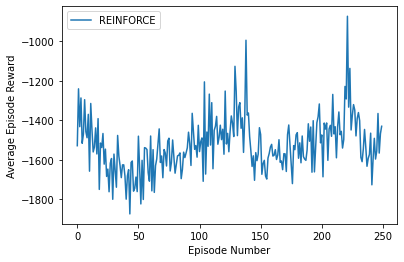

In [11]:
plt.plot(episodes, rewards, label="REINFORCE")
#plt.plot(episodes, rewards_1, label="Random")
plt.xlabel('Episode Number')
plt.ylabel('Average Episode Reward')
plt.legend()
plt.show()

In [9]:
%autoreload 2
# instantiate env
# env = LinearEnv(8,randomize=False, visualize=True)

s = env.reset()
print(np.array(s.ndim))
eps = 100
states = []

for i in range(eps):
    
    a = agent_mlp_tf(s)["Action"]
    s,r,done,_ = env.step(a)
    states.append(np.array([s,a]))
    if done:
        break

1


NameError: name 'time' is not defined

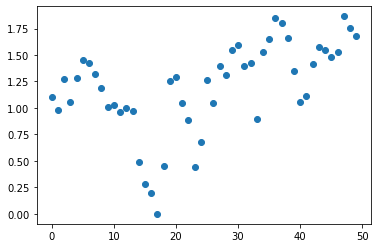

In [31]:
arr = np.array(states)
plt.scatter(list(range(arr.shape[0])),arr[:,0])

(array([ 3.,  3.,  9., 12.,  9.,  6.,  4.,  1.,  2.,  1.]),
 array([-0.52881972, -0.39593305, -0.26304638, -0.13015971,  0.00272696,
         0.13561363,  0.2685003 ,  0.40138697,  0.53427363,  0.6671603 ,
         0.80004697]),
 <BarContainer object of 10 artists>)

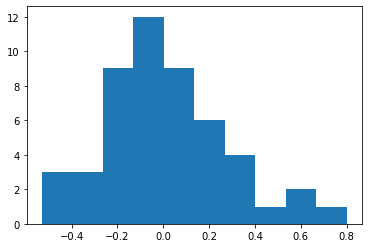

In [32]:
plt.hist(arr[:,1])

In [34]:
arr[:,0]

array([[1.09961885],
       [0.98330042],
       [1.26999753],
       [1.05813406],
       [1.28685379],
       [1.4484547 ],
       [1.42353711],
       [1.32425533],
       [1.18903123],
       [1.00501776],
       [1.02481764],
       [0.96545906],
       [0.99912104],
       [0.9743021 ],
       [0.49388741],
       [0.2784256 ],
       [0.19302302],
       [0.        ],
       [0.45013434],
       [1.25018131],
       [1.29462902],
       [1.04404767],
       [0.88540426],
       [0.43982745],
       [0.68045019],
       [1.2598574 ],
       [1.0429404 ],
       [1.39300582],
       [1.31566481],
       [1.54643011],
       [1.59790523],
       [1.39957961],
       [1.42463322],
       [0.8958135 ],
       [1.52666709],
       [1.65057185],
       [1.85013967],
       [1.79794047],
       [1.65971134],
       [1.3494707 ],
       [1.0553966 ],
       [1.11110036],
       [1.41792059],
       [1.57192421],
       [1.54869978],
       [1.48132564],
       [1.52878502],
       [1.865

In [27]:
env.reset()
for _ in range(1000):
    env.render()
    a = env.action_space.sample()
#     print(a)
#     print(type(a))
#     print(a.shape)
    print(env.step(a)) # take a random action
env.close()

(array([0.30375235, 0.95275102, 1.38029192]), -1.4430857285106187, False, {})
(array([0.21195128, 0.97728023, 1.90114906]), -1.7852555236503334, False, {})
(array([0.08176202, 0.99665188, 2.63435563]), -2.2034968865371782, False, {})
(array([-0.08157924,  0.99666686,  3.27046792]), -2.9114853359638575, False, {})
(array([-0.28445403,  0.95868968,  4.13533755]), -3.800853256982231, False, {})
(array([-0.50736366,  0.86173204,  4.87371603]), -5.166866441929995, False, {})
(array([-0.73126177,  0.68209693,  5.76094572]), -6.8001590410127175, False, {})
(array([-0.90875434,  0.41733146,  6.40239008]), -9.036319007385902, False, {})
(array([-0.99602285,  0.08909814,  6.82580813]), -11.449587968320225, False, {})
(array([-0.96919601, -0.24629067,  6.76135208]), -13.976932122264849, False, {})
(array([-0.84442214, -0.5356783 ,  6.3291932 ]), -12.942262772539417, False, {})
(array([-0.64499311, -0.76418838,  6.08942482]), -10.644263030219802, False, {})
(array([-0.40352588, -0.91496823,  5.712

(array([ 0.46860937, -0.88340549, -0.39045844]), -1.133502199700662, False, {})
(array([ 0.41948158, -0.90776385, -1.09683598]), -1.188394240272255, False, {})
(array([ 0.32454656, -0.94586972, -2.04683704]), -1.4183921033065274, False, {})
(array([ 0.2002392 , -0.97974704, -2.57860473]), -1.9586114530283913, False, {})
(array([ 0.03738913, -0.99930078, -3.28408421]), -2.5396514099233927, False, {})
(array([-0.15428672, -0.98802612, -3.84606672]), -3.4313941855261056, False, {})
(array([-0.38564866, -0.92264571, -4.82010558]), -4.459682911991758, False, {})
(array([-0.63237218, -0.77466472, -5.77401662]), -6.194327700794536, False, {})
(array([-0.83604966, -0.54865377, -6.10863148]), -8.42348968586976, False, {})
(array([-0.96853704, -0.24886945, -6.58480706]), -10.28962274946328, False, {})
(array([-0.9956899 ,  0.0927449 , -6.88782352]), -12.689131748126309, False, {})
(array([-0.90269231,  0.43028664, -7.03863831]), -14.041028478500047, False, {})
(array([-0.71244822,  0.70172468, -

(array([ 0.60028681, -0.79978481,  0.67508176]), -1.0423999536871595, True, {'TimeLimit.truncated': True})
(array([ 0.60206192, -0.7984494 ,  0.04442658]), -0.9048273039032608, True, {'TimeLimit.truncated': True})
(array([ 0.5807924 , -0.81405171, -0.52758503]), -0.8553277851892558, True, {'TimeLimit.truncated': True})
(array([ 0.53504999, -0.8448204 , -1.10269677]), -0.9324712687144188, True, {'TimeLimit.truncated': True})
(array([ 0.45503027, -0.89047597, -1.84321412]), -1.1345995629965808, True, {'TimeLimit.truncated': True})
(array([ 0.35356351, -0.93541052, -2.22056537]), -1.5499555112640206, True, {'TimeLimit.truncated': True})
(array([ 0.21562597, -0.97647603, -2.88090206]), -1.955859413045342, True, {'TimeLimit.truncated': True})
(array([ 0.03626083, -0.99934236, -3.62128109]), -2.6618259488522216, True, {'TimeLimit.truncated': True})
(array([-0.19418454, -0.98096502, -4.63389758]), -3.6692192021137164, True, {'TimeLimit.truncated': True})
(array([-0.45012313, -0.8929665 , -5.4

(array([-0.9948995 , -0.10087117, -7.79491573]), -12.715636766838172, True, {'TimeLimit.truncated': True})
(array([-0.95694899,  0.29025613, -7.91074997]), -15.321084993197571, True, {'TimeLimit.truncated': True})
(array([-0.77989098,  0.62591538, -7.63620448]), -14.364108149903672, True, {'TimeLimit.truncated': True})
(array([-0.50949036,  0.86047636, -7.19798418]), -11.90884984512465, True, {'TimeLimit.truncated': True})
(array([-0.206773  ,  0.97838894, -6.52633765]), -9.613790070657025, True, {'TimeLimit.truncated': True})
(array([ 0.08909047,  0.99602354, -5.94968548]), -7.425502429040458, True, {'TimeLimit.truncated': True})
(array([ 0.35047185,  0.93657327, -5.37732221]), -5.736333227086191, True, {'TimeLimit.truncated': True})
(array([ 0.55931891,  0.82895257, -4.70978178]), -4.362306876852251, True, {'TimeLimit.truncated': True})
(array([ 0.70990481,  0.70429764, -3.91598199]), -3.174503714970514, True, {'TimeLimit.truncated': True})
(array([ 0.82308471,  0.56791863, -3.549167

(array([-0.69219164, -0.72171375, -6.82086483]), -7.588613176522919, True, {'TimeLimit.truncated': True})
(array([-0.90817516, -0.41859034, -7.48764774]), -10.106828407895419, True, {'TimeLimit.truncated': True})
(array([-0.99917091, -0.04071238, -7.82337876]), -12.948982483873678, True, {'TimeLimit.truncated': True})
(array([-0.93734233,  0.34840976, -7.93195325]), -15.73618486177281, True, {'TimeLimit.truncated': True})
(array([-0.74782277,  0.66389841, -7.40291532]), -14.055002272045417, True, {'TimeLimit.truncated': True})
(array([-0.48718102,  0.87330101, -6.7183532 ]), -11.31685594344939, True, {'TimeLimit.truncated': True})
(array([-0.19719441,  0.9803644 , -6.20727134]), -8.839512968752425, True, {'TimeLimit.truncated': True})
(array([ 0.06126353,  0.99812163, -5.1959446 ]), -6.986801545401757, True, {'TimeLimit.truncated': True})
(array([ 0.27964613,  0.96010314, -4.4424719 ]), -4.978358445419118, True, {'TimeLimit.truncated': True})
(array([ 0.44591876,  0.89507344, -3.575498

(array([ 0.16448518, -0.98637955, -1.54036529]), -1.8276429055857513, True, {'TimeLimit.truncated': True})
(array([ 0.04236375, -0.99910225, -2.45719251]), -2.2142652601196118, True, {'TimeLimit.truncated': True})
(array([-0.11165033, -0.99374756, -3.08520089]), -2.9405010123334825, True, {'TimeLimit.truncated': True})
(array([-0.28829593, -0.95754136, -3.6112623 ]), -3.785394682495591, True, {'TimeLimit.truncated': True})
(array([-0.47588402, -0.87950804, -4.07044323]), -4.778777021615397, True, {'TimeLimit.truncated': True})
(array([-0.66241528, -0.74913684, -4.56138751]), -5.929633937040283, True, {'TimeLimit.truncated': True})
(array([-0.82625003, -0.56330356, -4.9675887 ]), -7.347968168475031, True, {'TimeLimit.truncated': True})
(array([-0.94884951, -0.31572869, -5.54308198]), -8.936671944848326, True, {'TimeLimit.truncated': True})
(array([-0.99982555, -0.01867806, -6.05090776]), -11.030316888913106, True, {'TimeLimit.truncated': True})
(array([-0.95878356,  0.28413745, -6.13571

(array([ 0.58812801, -0.80876786, -0.6776327 ]), -0.8250561777511447, True, {'TimeLimit.truncated': True})
(array([ 0.52741174, -0.84960982, -1.46381986]), -0.9348182569387826, True, {'TimeLimit.truncated': True})
(array([ 0.43797298, -0.89898814, -2.04417231]), -1.2451430541240025, True, {'TimeLimit.truncated': True})
(array([ 0.31526194, -0.94900469, -2.65219989]), -1.6667616110667984, True, {'TimeLimit.truncated': True})
(array([ 0.14233421, -0.98981866, -3.55826841]), -2.267753751017618, True, {'TimeLimit.truncated': True})
(array([-0.05841127, -0.9982926 , -4.02527546]), -3.308615814209362, True, {'TimeLimit.truncated': True})
(array([-0.30344382, -0.95284933, -4.9972057 ]), -4.276924400047396, True, {'TimeLimit.truncated': True})
(array([-0.56954006, -0.82196358, -5.95282722]), -6.0308086525935485, True, {'TimeLimit.truncated': True})
(array([-0.79721388, -0.60369697, -6.33439552]), -8.28427558465479, True, {'TimeLimit.truncated': True})
(array([-0.95309993, -0.30265579, -6.81304

(array([0.97508707, 0.22182248, 2.51012195]), -0.4720718176547512, True, {'TimeLimit.truncated': True})
(array([0.93203516, 0.36236786, 2.94248101]), -0.6832498859575336, True, {'TimeLimit.truncated': True})
(array([0.86464115, 0.50238998, 3.11107029]), -1.0037906315595317, True, {'TimeLimit.truncated': True})
(array([0.77227059, 0.63529374, 3.24056253]), -1.2476495153534486, True, {'TimeLimit.truncated': True})
(array([0.64139164, 0.76721364, 3.72193464]), -1.5240047766491698, True, {'TimeLimit.truncated': True})
(array([0.45438116, 0.89080737, 4.4926678 ]), -2.1517003157099532, True, {'TimeLimit.truncated': True})
(array([0.22008021, 0.97548178, 4.99561398]), -3.227681164221086, True, {'TimeLimit.truncated': True})
(array([-0.05632072,  0.99841273,  5.56494455]), -4.316316568828357, True, {'TimeLimit.truncated': True})
(array([-0.37095353,  0.92865143,  6.47370134]), -5.745604719062257, True, {'TimeLimit.truncated': True})
(array([-0.68059626,  0.73265868,  7.37081102]), -7.998414947

KeyboardInterrupt: 

In [30]:
a = np.array([0.30375235, 0.95275102, 1.38029192])

True